In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.read_hdf('../generated/topics_rates.hdf5.csv.9', stop=10).head()

,topic_id,platform,traffic_source,geo,topic_viewed
0,0,1,1,-1,20.310514
1,0,1,1,0,38.536388
2,0,1,1,1,4.740327
3,0,1,1,2,0.186612
4,0,1,1,4,0.037480


In [2]:
topics_rates = pd.read_hdf('../generated/topics_rates.hdf5.csv.9')
topics_rates = pd.DataFrame({'weight':(topics_rates.groupby('topic_id')['topic_viewed'].sum() / sum(topics_rates['topic_viewed']))}).reset_index()
topics_rates['weight_sqrt'] = np.sqrt(topics_rates['weight'])
topics_rates.head()

,topic_id,weight,weight_sqrt
0,0,0.001387,0.037248
1,1,0.001743,0.041751
2,2,0.001504,0.038775
3,3,0.000857,0.029275
4,4,0.001428,0.037784


In [3]:
topics_rates.count()

topic_id       300
weight         300
weight_sqrt    300
dtype: int64

In [4]:
sum(topics_rates['weight'])

0.9999999999999672

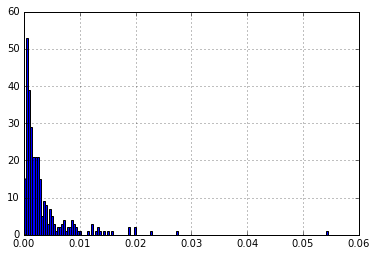

In [5]:
topics_rates['weight'].hist(bins=150)

In [6]:
docs_topics = pd.read_csv("../download/documents_topics.csv")
docs_topics.head()

,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


In [7]:
docs_topics = docs_topics.merge(topics_rates, on='topic_id', how='left').fillna(0)
docs_topics['value']=docs_topics['confidence_level']*docs_topics['weight_sqrt']
docs_topics['value2']=np.square(docs_topics['value'])
docs_topics.drop(['confidence_level','weight','weight_sqrt'], axis=1, inplace=True)
docs_topics.head()

,document_id,topic_id,value,value2
0,1595802,140,0.017072,0.000291
1,1595802,16,0.009866,0.000097
2,1595802,143,0.006252,0.000039
3,1595802,170,0.001958,0.000004
4,1524246,113,0.010448,0.000109


In [8]:
docs_norms2 = pd.DataFrame({'norm2':docs_topics.groupby(['document_id'])['value2'].sum()}).reset_index()
docs_topics.drop(['value2'], axis=1, inplace=True)
docs_norms2.head()

,document_id,norm2
0,1,0.000010
1,2,0.000003
2,3,0.000018
3,4,0.000252
4,5,0.000160


In [9]:
page_addoc_dist = pd.read_csv("../generated/final/events_clicks_CTR_addocs_train.csv", usecols=['document_id', 'addoc_id'])
page_addoc_dist.count()

document_id    87141731
addoc_id       87141731
dtype: int64

In [10]:
page_addoc_dist = pd.DataFrame({'size':page_addoc_dist.groupby(['document_id', 'addoc_id']).size()}).reset_index().drop(['size'], axis=1)
page_addoc_dist.count()

document_id    28491064
addoc_id       28491064
dtype: int64

In [11]:
len(page_addoc_dist.document_id.unique()), len(page_addoc_dist.addoc_id.unique())

(756510, 164476)

In [12]:
page_addoc_diffs = page_addoc_dist.merge(docs_topics, left_on='addoc_id', right_on='document_id')
page_addoc_diffs.rename(columns={'document_id_x':'document_id'}, inplace=True)
page_addoc_diffs.drop(['document_id_y'], axis=1, inplace=True)
page_addoc_diffs = page_addoc_diffs.merge(docs_topics, on=['document_id', 'topic_id'])
page_addoc_diffs['value_2xy'] = 2*page_addoc_diffs['value_x']*page_addoc_diffs['value_y']
page_addoc_diffs.drop(['topic_id', 'value_x', 'value_y'], axis=1, inplace=True)
page_addoc_diffs = pd.DataFrame({'value_2xy':page_addoc_diffs.groupby(['document_id', 'addoc_id'])['value_2xy'].sum()}).reset_index()

page_addoc_diffs.head()

,document_id,addoc_id,value_2xy
0,5,1044364,0.000274
1,5,1332140,0.000125
2,5,1354106,0.000326
3,5,1644537,0.000443
4,5,2348772,0.000387


In [13]:
page_addoc_diffs.count()

document_id    3867799
addoc_id       3867799
value_2xy      3867799
dtype: int64

In [14]:
page_addoc_dist = page_addoc_dist.merge(docs_norms2, on=['document_id'])
page_addoc_dist = page_addoc_dist.merge(docs_norms2, left_on=['addoc_id'], right_on=['document_id'])
page_addoc_dist.rename(columns={'document_id_x':'document_id'}, inplace=True)
page_addoc_dist.drop(['document_id_y'], axis=1, inplace=True)
page_addoc_dist = page_addoc_dist.merge(page_addoc_diffs, on=['document_id', 'addoc_id'], how='left').fillna(0)
page_addoc_dist['dist'] = np.sqrt( page_addoc_dist['norm2_x'] + page_addoc_dist['norm2_y'] - page_addoc_dist['value_2xy'] )
page_addoc_dist.drop(['norm2_x', 'norm2_y', 'value_2xy'], axis=1, inplace=True)

page_addoc_dist.head()

,document_id,addoc_id,dist
0,2,1489042,0.038507
1,452,1489042,0.038783
2,515,1489042,0.038507
3,1608,1489042,0.038583
4,3260,1489042,0.038796


In [15]:
page_addoc_dist.to_csv("../generated/final/page_addoc_topics_dist.csv", index=False)

In [16]:
page_addoc_dist.count()

document_id    25884504
addoc_id       25884504
dist           25884504
dtype: int64